# Compare photometry in the new and old Stripe82 catalogs

[Link to helper tools](#dataTools) 

[Link to data reading](#dataReading) 

[Link to data analysis](#dataAnalysis) 

In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

<a id='dataTools'></a>

### Helper Tools

In [2]:
### selection tools and numerical analysis 

# robust standard deviation
def sigG(arr):
    return 0.741*(np.quantile(arr, 0.75)-np.quantile(arr, 0.25))

def checkNobs(d, band):
    str1 = band + '_Nobs_old'
    arr1 = d[str1]
    print(band, 'band, OLD:')
    printStats(arr1)
    str1 = band + '_Nobs_new'
    arr1 = d[str1]
    print('        NEW:')
    printStats(arr1)
    print('      DIFF:')
    str2 = 'd' + band
    arr2 = d[str2]
    printStats(arr2)
    return
  
def printStats(arr):
    print('           ', np.min(arr), np.median(arr), np.max(arr)) 
    return 

# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0
            medianBin[i] = 0
            sigGbin[i] = 0
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]), 'std.dev:', np.std(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [3]:
### plots 

# quick plot 
def qp(d, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax):
    ax = plt.axes()
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.scatter(d[Xstr], d[Ystr], s=0.01, c='blue')  
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return

# quick plot - compare three subsamples
def qp3(d1, d2, d3, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax):
    ax = plt.axes()
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.scatter(d1[Xstr], d1[Ystr], s=0.01, c='green') 
    ax.scatter(d2[Xstr], d2[Ystr], s=0.01, c='red') 
    ax.scatter(d3[Xstr], d3[Ystr], s=0.01, c='blue') 
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return

# quick plot - binned median
def qpBM(d, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax, nBin, Nsigma=3, offset=0.01):
    ax = plt.axes()
    ax.scatter(d[Xstr], d[Ystr], s=0.01, c='black') 
    # binning
    xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(d[Xstr], d[Ystr], Xmin, Xmax, nBin, 1)
    # plotting
    ax.scatter(xBinM, medianBinM, s=30.0, c='black', alpha=0.8)
    ax.scatter(xBinM, medianBinM, s=15.0, c='yellow', alpha=0.3)
    #
    TwoSigP = medianBinM + Nsigma*sigGbinM
    TwoSigM = medianBinM - Nsigma*sigGbinM 
    ax.plot(xBinM, TwoSigP, c='yellow')
    ax.plot(xBinM, TwoSigM, c='yellow')
    #
    rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
    rmsP = medianBinM + rmsBin
    rmsM = medianBinM - rmsBin
    ax.plot(xBinM, rmsP, c='cyan')
    ax.plot(xBinM, rmsM, c='cyan')
    # 
    xL = np.linspace(-100,100)
    ax.plot(xL, 0*xL+offset, c='red')
    ax.plot(xL, 0*xL-offset, c='red')
    # 
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return
 
def qphist(arr, xMin, xMax, xLabel, verbose = False):
    ax = plt.axes()
    hist(arr, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    plt.show()
    if (verbose):
        print('Min, max: ', np.min(arr),np.max(arr)) 
        print('Mean, median: ', np.mean(arr),np.median(arr)) 
        print('sigG, st.dev.: ', sigG(arr),np.std(arr)) 
    return 

def qpH0(arr, xMin, xMax, xLabel, nBins=0, verbose = False):
    ax = plt.axes()
    if (nBins>0):
        hist, bins = np.histogram(arr, bins=nBins)
        center = (bins[:-1]+bins[1:])/2
        ax.plot(center, hist, drawstyle='steps', c='blue')   
    else:
        plt.hist(arr, bins='auto', histtype='stepfilled', ec='k', fc='red') 
 
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    ax.plot([-1000, 1000], [0, 0], '--k')
    plt.show()
    if (verbose):
        print('Min, max: ', np.min(arr),np.max(arr)) 
        print('Mean, median: ', np.mean(arr),np.median(arr)) 
        print('sigG, st.dev.: ', sigG(arr),np.std(arr))  
    return 

def qpHdm(d, band, dmMax, xMin, xMax, nBins=50, verbose=False):
    str = 'd' + band
    dm = 1000*d[str]
    dmOK = dm[np.abs(dm)<(1000*dmMax)]
    xLabel = str + ' (milimag)'
    qpH0(dmOK, 1000*xMin, 1000*xMax, xLabel, nBins, verbose)
    return np.mean(dmOK), np.median(dmOK), sigG(dmOK)


def qp2hist(arr1, arr2, xMin, xMax, xLabel, nBins=0, verbose = False):
    ax = plt.axes()
    if (nBins>0):
        hist, bins = np.histogram(arr1, bins=nBins)
        center = (bins[:-1]+bins[1:])/2
        ax.plot(center, hist, drawstyle='steps', c='red')   
        hist2, bins2 = np.histogram(arr2, bins=nBins)
        center2 = (bins2[:-1]+bins2[1:])/2
        ax.plot(center2, hist2, drawstyle='steps', c='blue')   
    else:
        plt.hist(arr1, bins='auto', histtype='stepfilled', ec='k', fc='yellow')
        plt.hist(arr2, bins='auto', histtype='stepfilled', ec='red', fc='blue')
 
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    plt.show()
    if (verbose):
        print('Min: ', np.min(arr1),np.min(arr2)) 
        print('Median: ', np.median(arr1),np.median(arr2)) 
        print('sigG: ', sigG(arr1),sigG(arr2)) 
        print('Max: ', np.max(arr1),np.max(arr2)) 
    return 

<a id='dataReading'></a>

### Define paths and catalogs 

In [4]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/Data"
# the original SDSS catalog from 2007
sdssOldCat = ZIdataDir + "/" + "stripe82calibStars_v2.6.dat"
# Karun's new catalog from 2020
sdssNewCat = ZIdataDir + "/" + "NEW_stripe82calibStars_v0.dat" 

In [5]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [6]:
%%time
# old
sdssOld = Table.read(sdssOldCat, format='ascii', names=colnamesSDSS) 
np.size(sdssOld)

CPU times: user 23 s, sys: 5.41 s, total: 28.4 s
Wall time: 28.8 s


1006849

In [8]:
%%time
# new 
## ZI version
sdssNewCat = '/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Analysis_2020/newSSC.dat'

sdssNewRaw = Table.read(sdssNewCat, format='ascii', names=colnamesSDSS)
# rejects objects with bad Declination, sample size from 1007136 to 1005470 
sdssNew = sdssNewRaw[sdssNewRaw['dec']<90]
np.size(sdssNew)

CPU times: user 53 s, sys: 22.2 s, total: 1min 15s
Wall time: 1min 17s


1001335

#### Simple positional match using ra/dec

In [9]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  

In [10]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
new_old = hstack([sdssNew, sdssOld[idx]], table_names = ['new', 'old'])
new_old['sep_2d_arcsec'] = d2d.arcsec
# since we matched sdssNew to sdssOld, the resulting catalog has the same lengthas sdssNew: 1005470

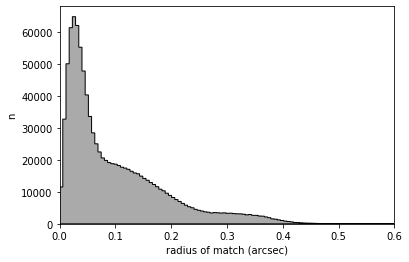

Min, max:  0.0 9.92323684811727
Mean, median:  0.10310270046428843 0.06604502406209317
sigG, st.dev.:  0.08325897988978277 0.17194771284079682


In [11]:
qphist(d2d.arcsec, 0.0, 0.6, 'radius of match (arcsec)', True)

### Select good matches and compare new vs. old magnitudes

In [12]:
## first limit astrometric distance and 
## require at least 4 epochs as in the old catalog
MAX_DISTANCE_ARCSEC = 0.5
m1 = new_old[(new_old['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
a1 = m1['g_Nobs_new']
a2 = m1['r_Nobs_new']
a3 = m1['i_Nobs_new']
mOK = m1[(a1>3)&(a2>3)&(a3>3)]
print(len(new_old))
print(len(m1))
print(len(mOK))

1001335
1000140
996147


In [13]:
for b in ('u', 'g', 'r', 'i', 'z'):
    str1 = b + '_Nobs_old'
    str2 = b + '_Nobs_new'
    print(b, np.sum(mOK[str1]), np.sum(mOK[str2]))

u 4890118 10901403
g 9237438 16959668
r 9265099 17294704
i 9265820 17295408
z 9236689 17066869


In [14]:
## additional constraints for the u and z band:
## require at least 4 epochs both in the old and new catalogs 
mOKu = mOK[(mOK['u_Nobs_old']>3)&(mOK['u_Nobs_new']>3)]
mOKz = mOK[(mOK['z_Nobs_old']>3)&(mOK['u_Nobs_new']>3)]
print(len(mOK))
print(len(mOKu))
print(len(mOKz))

996147
529948
855466


In [15]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    matches['ra'] = matches['ra_old']
    ra = matches['ra'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dec'] = matches['dec_old']
    matches['u'] = matches['u_mMed_old']
    matches['g'] = matches['g_mMed_old']
    matches['r'] = matches['r_mMed_old']
    matches['i'] = matches['i_mMed_old']
    matches['z'] = matches['z_mMed_old']
    matches['ug'] = matches['u_mMed_old'] - matches['g_mMed_old']
    matches['gr'] = matches['g_mMed_old'] - matches['r_mMed_old']
    matches['ri'] = matches['r_mMed_old'] - matches['i_mMed_old']
    matches['gi'] = matches['g_mMed_old'] - matches['i_mMed_old']
    matches['du'] = matches['u_mMed_old'] - matches['u_mMed_new']
    matches['dg'] = matches['g_mMed_old'] - matches['g_mMed_new']
    matches['dr'] = matches['r_mMed_old'] - matches['r_mMed_new']
    matches['di'] = matches['i_mMed_old'] - matches['i_mMed_new']
    matches['dz'] = matches['z_mMed_old'] - matches['z_mMed_new']
    return

In [16]:
derivedColumns(mOK)
derivedColumns(mOKu)
derivedColumns(mOKz)

#### A few sanity checks plots...

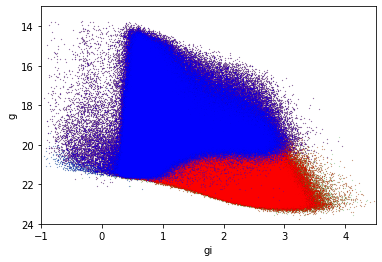

In [17]:
qp3(mOK, mOKz, mOKu, 'gi', -1.0, 4.5, 'g', 24, 13)

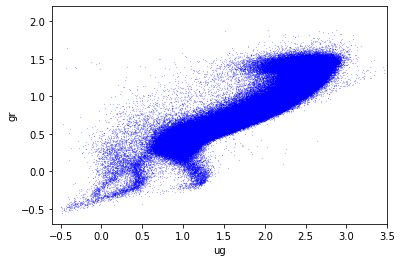

In [18]:
qp(mOKu, 'ug', -0.6, 3.5, 'gr', -0.7, 2.2) 

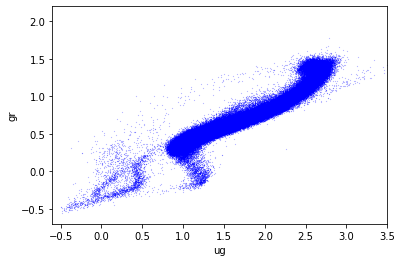

In [19]:
mOKuB = mOKu[mOKu['u']<21]
qp(mOKuB, 'ug', -0.6, 3.5, 'gr', -0.7, 2.2) 

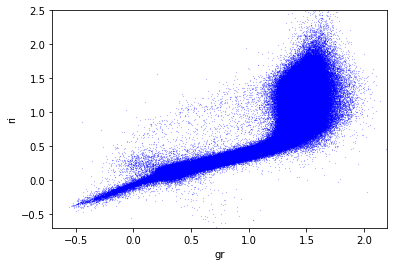

In [20]:
qp(mOK, 'gr', -0.7, 2.2, 'ri', -0.7, 2.5) 

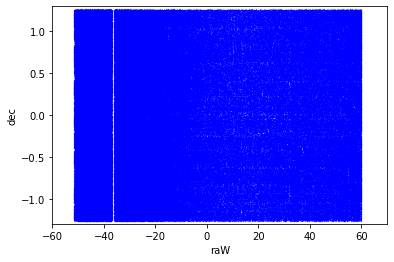

In [21]:
qp(mOK, 'raW', -60, 70, 'dec', -1.3, 1.3) 

#### Nothing weird showed up; let's now do a detailed comparison and quantify improvements

In [22]:
checkNobs(mOKu, 'u')
checkNobs(mOK, 'g')
checkNobs(mOK, 'r')
checkNobs(mOK, 'i') 
checkNobs(mOKz, 'z') 

u band, OLD:
            4 8.0 28
        NEW:
            4 15.0 75
      DIFF:
            -9999.917 -0.0070000000000014495 10021.655999999999
g band, OLD:
            4 9.0 28
        NEW:
            4 15.0 94
      DIFF:
            -5.318000000000001 -0.0010000000000012221 10022.198999999999
r band, OLD:
            4 9.0 28
        NEW:
            4 16.0 69
      DIFF:
            -5.687000000000001 0.0 10020.546
i band, OLD:
            4 9.0 28
        NEW:
            4 16.0 73
      DIFF:
            -5.518000000000001 0.0 10020.475
z band, OLD:
            4 9.0 28
        NEW:
            0 16.0 62
      DIFF:
            -4.448 -0.0010000000000012221 10020.333999999999


In [23]:
mOK2 = mOK[mOK['r_chi2_new']<10]
print(np.size(mOK), np.size(mOK2))

996147 995944


In [24]:
mOKB = mOK[mOK['r_mMed_new']<21]
print(np.size(mOK), np.size(mOKB))

996147 851521


In [25]:
mOKc1 = mOK[(mOK['r_chi2_new']<3)&(mOK['i_chi2_new']>20)&(mOK['i_chi2_new']<1000)]
mOKc2 = mOK[(mOK['r_chi2_new']>20)&(mOK['i_chi2_new']<3)&(mOK['r_chi2_new']<1000)]
mOKc3 = mOK[(mOK['r_chi2_new']>20)&(mOK['i_chi2_new']>20)&(mOK['r_chi2_new']<1000)&(mOK['i_chi2_new']<1000)]
print(np.size(mOK), np.size(mOKc1), np.size(mOKc2), np.size(mOKc3))

996147 97 71 7


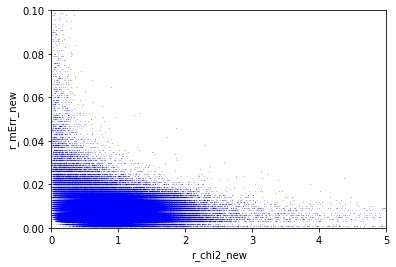

In [30]:
qp(mOKB, 'r_chi2_new', 0, 5, 'r_mErr_new', 0, 0.1) 

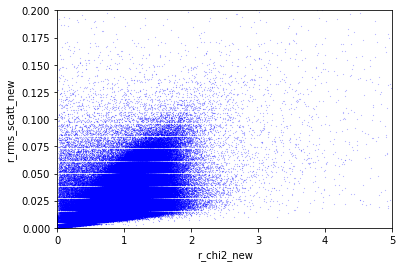

In [29]:
qp(mOKB, 'r_chi2_new', 0, 5, 'r_rms_scatt_new', 0, 0.2) 

In [46]:
### variables
mOKvar = mOK[(mOK['r_chi2_new']>3) & (mOK['r_Nobs_new']>10)]
print(np.size(mOKvar))

949


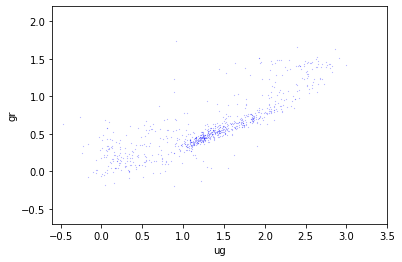

In [47]:
qp(mOKvar, 'ug', -0.6, 3.5, 'gr', -0.7, 2.2) 

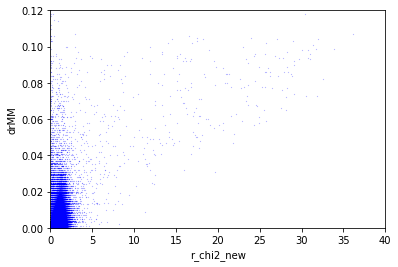

In [48]:
mOKB['drMM'] = mOKB['r_mMean_new'] - mOKB['r_mMed_new']
np.std(mOKB['drMM'])
qp(mOKB, 'r_chi2_new', 0, 40, 'drMM', 0, 0.12) 

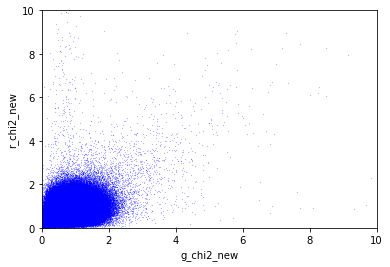

In [51]:
qp(mOKB, 'g_chi2_new', 0, 10, 'r_chi2_new', 0, 10) 

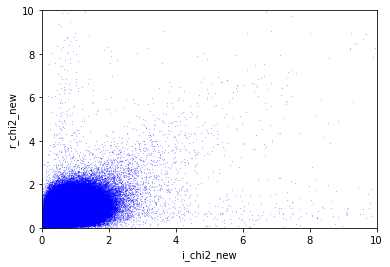

In [52]:
qp(mOKB, 'i_chi2_new', 0, 10, 'r_chi2_new', 0, 10) 

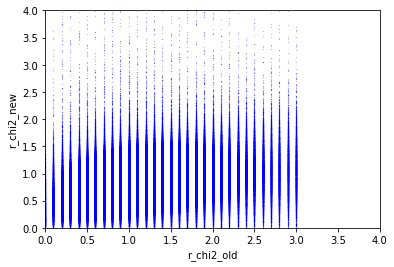

In [54]:
qp(mOK, 'r_chi2_old', 0, 4, 'r_chi2_new', 0, 4) 

In [56]:
def makeAllPlots(d, b, dmMax=0.05):
    str1 = b + '_Nobs_old'
    str2 = b + '_Nobs_new'
    str3 = 'Nobs(' + b + ')'
    str4 = 'd' + b
    str5 = b + '_chi2_old'
    str6 = b + '_chi2_new'
    str7 = 'chi2(' + b + ')'
    qp2hist(d[str1], d[str2], 0, 50, str3, 51, True)
    qp2hist(d[str5], d[str6], 0, 5, str7, 51, True)
    meanDM, medianDM, sigDM = qpHdm(d, b, 0.1, -0.1, 0.1, 50, True)
    # binned medians of dm vs. both coordinates, magnitude and color
    qpBM(d, 'raW', -51.5, 60.0, str4, -1*dmMax, dmMax, 500) 
    qpBM(d, 'dec', -1.3, 1.3, str4, -1*dmMax, dmMax, 120) 
    qpBM(d, b, 14, 23.0, str4, -1*dmMax, dmMax, 150) 
    qpBM(d, 'gi', -0.7, 3.5, str4, -1*dmMax, dmMax, 150) 
    return meanDM, medianDM, sigDM

In [57]:
mOK2 = mOK[(mOK['g_chi2_new']<10)&(mOK['r_chi2_new']<10)&(mOK['i_chi2_new']<10)]
print(np.size(mOK), np.size(mOK2))

996147 995670


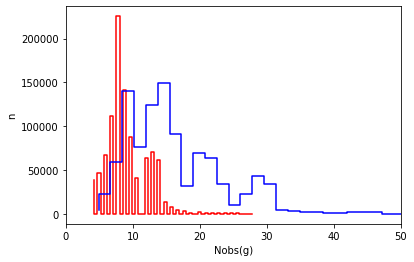

Min:  4 4
Median:  9.0 15.0
sigG:  2.964 6.669
Max:  28 94


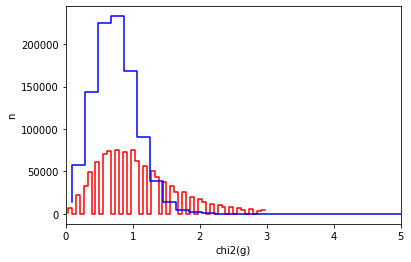

Min:  0.0 0.0
Median:  1.0 0.818
sigG:  0.5186999999999999 0.31566600000000006
Max:  3.0 9.847


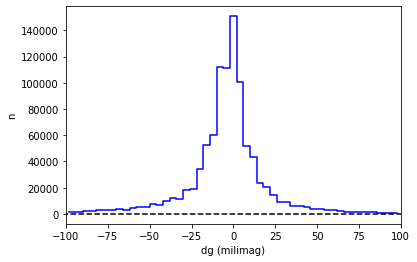

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -2.09810612204159 -1.0000000000012221
sigG, st.dev.:  12.5969999999996 23.281367906858208
median: -0.0010000000000012221 std.dev: 0.0005275909455154905


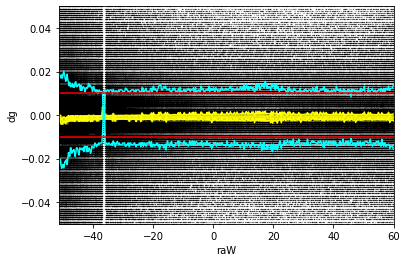

median: -0.0010000000000012221 std.dev: 0.0037334812849438696


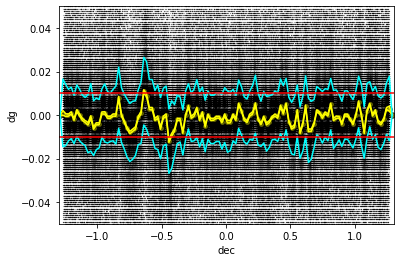

median: -0.0009999999999976694 std.dev: 0.0015553527645591823


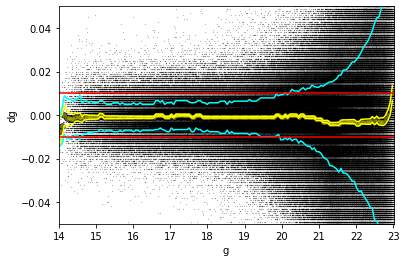

median: -0.0010000000000012221 std.dev: 0.0014346854087993396


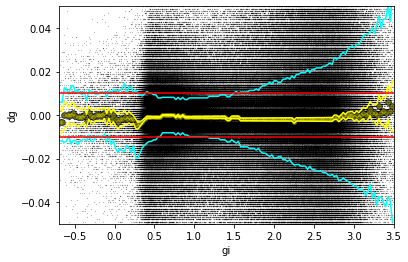

BAND g :  -2.09810612204159 -1.0000000000012221 12.5969999999996


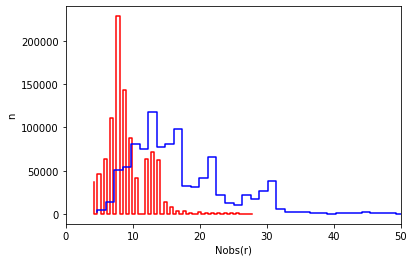

Min:  4 4
Median:  9.0 16.0
sigG:  2.964 6.669
Max:  28 69


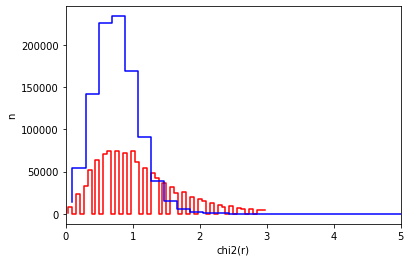

Min:  0.0 0.0
Median:  1.0 0.829
sigG:  0.5928 0.317889
Max:  3.0 9.946


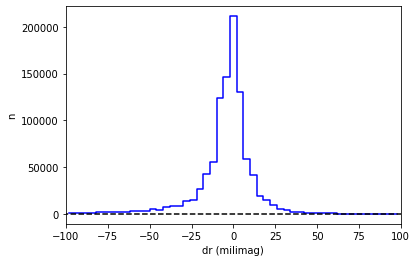

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -2.3677056297221992 0.0
sigG, st.dev.:  8.891999999997704 16.73064730066916
median: 0.0 std.dev: 0.0004338594610674656


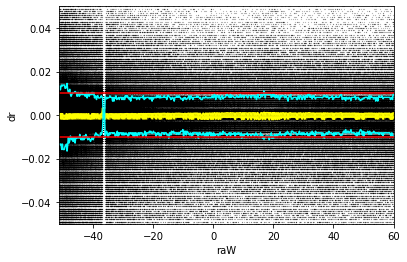

median: -0.0004999999999988347 std.dev: 0.002851301380658156


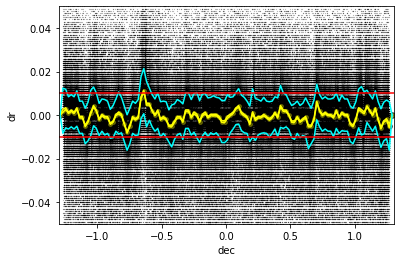

median: 0.0 std.dev: 0.009818523042845122


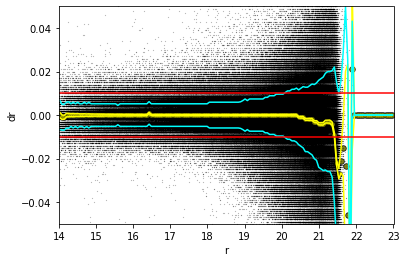

median: 0.0 std.dev: 0.0010619478957713832


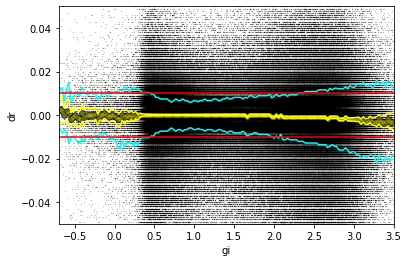

BAND r :  -2.3677056297221992 0.0 8.891999999997704


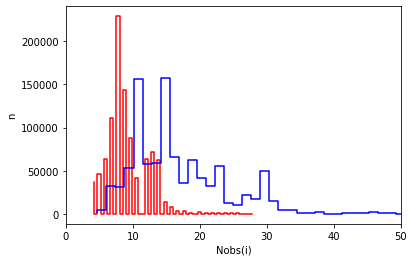

Min:  4 4
Median:  9.0 16.0
sigG:  2.964 6.669
Max:  28 73


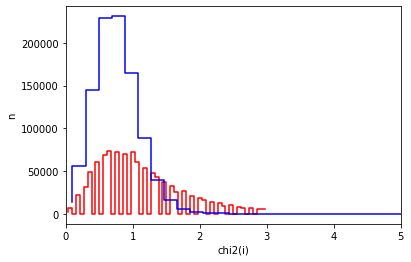

Min:  0.0 0.0
Median:  1.0 0.824
sigG:  0.5928 0.320112
Max:  3.0 9.951


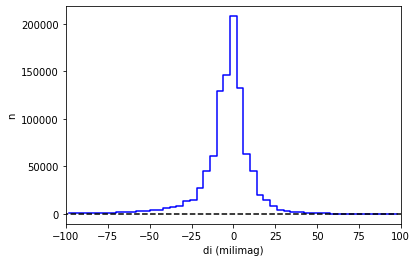

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -1.8053145352660789 0.0
sigG, st.dev.:  8.892000000000337 15.196889725212129
median: 0.0 std.dev: 0.00039364437287336805


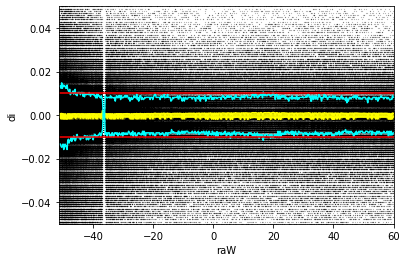

median: 0.0 std.dev: 0.0033569592675923516


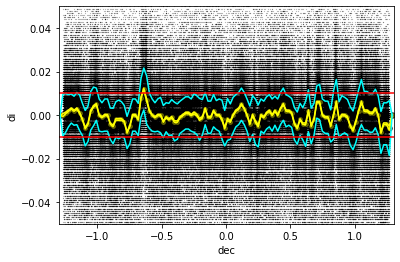

median: 0.0 std.dev: 0.011311388824842948


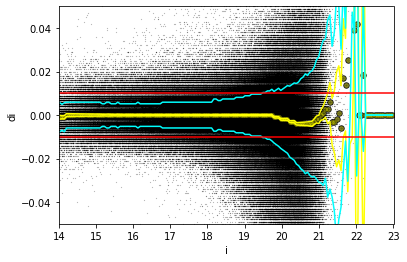

median: 0.0 std.dev: 0.0010232899013581384


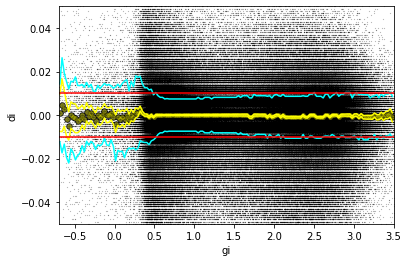

BAND i :  -1.8053145352660789 0.0 8.892000000000337


In [58]:
for b in ('g', 'r', 'i'):
    meanDM, medianDM, sigDM = makeAllPlots(mOK2, b)
    print('BAND', b, ': ', meanDM, medianDM, sigDM)

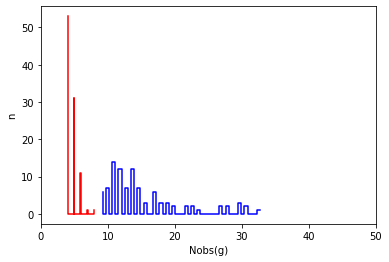

Min:  4 9
Median:  4.0 14.0
sigG:  0.741 4.446
Max:  8 33


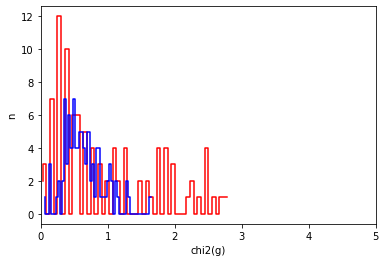

Min:  0.0 0.044
Median:  0.7 0.611
sigG:  0.8892000000000001 0.28528499999999996
Max:  2.8 1.663


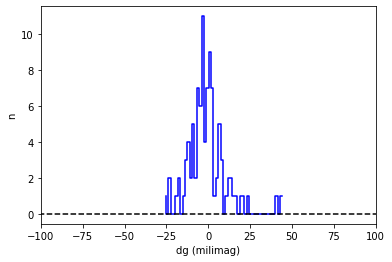

Min, max:  -25.9999999999998 45.000000000001705
Mean, median:  -0.20618556701017668 -0.9999999999994458
sigG, st.dev.:  6.669000000000253 11.137322916157155
median: -0.0009999999999994458 std.dev: 0.011562767321284223


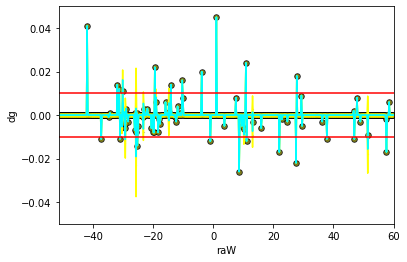

median: -0.0009999999999994458 std.dev: 0.01171693453947165


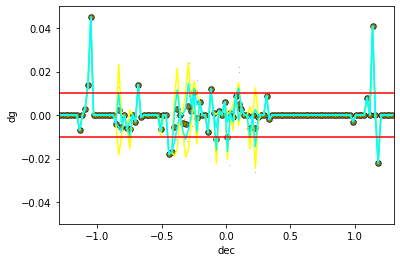

median: -0.0009999999999994458 std.dev: 0.011200619516393574


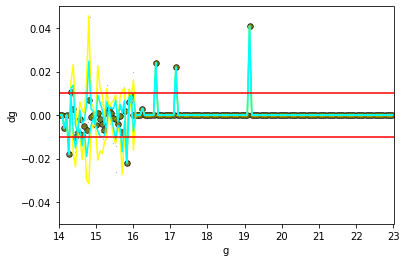

median: -0.0009999999999994458 std.dev: 0.00843932593411453


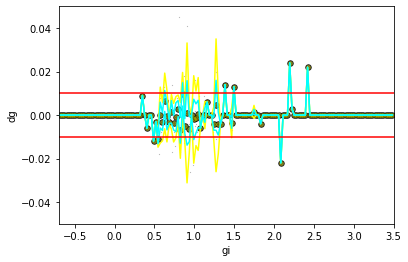

BAND g :  -0.20618556701017668 -0.9999999999994458 6.669000000000253


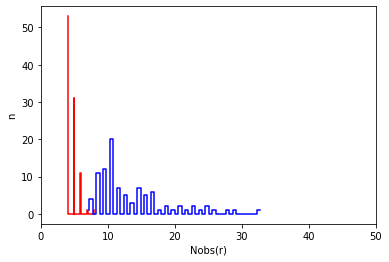

Min:  4 7
Median:  4.0 12.0
sigG:  0.741 4.446
Max:  8 33


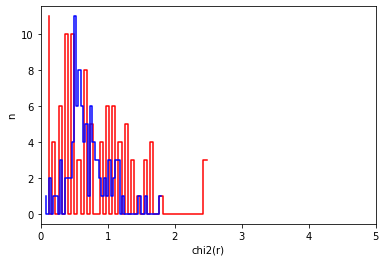

Min:  0.1 0.065
Median:  0.7 0.648
sigG:  0.5187 0.23934299999999997
Max:  2.5 1.815


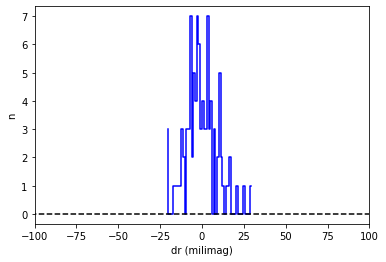

Min, max:  -21.000000000000796 29.99999999999936
Mean, median:  0.3092783505154573 -0.9999999999994458
sigG, st.dev.:  8.150999999999431 9.321697142878406
median: -0.0009999999999994458 std.dev: 0.009418347109243302


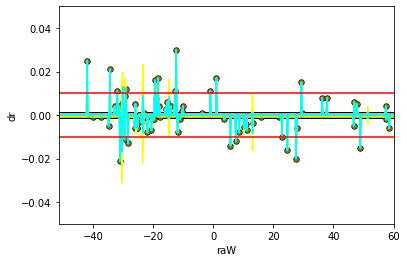

median: 0.0 std.dev: 0.009662339092611097


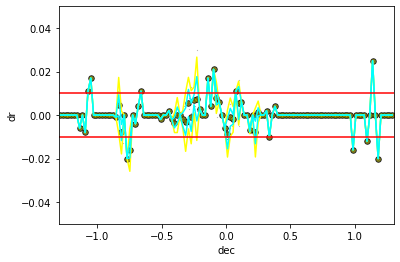

median: 0.0 std.dev: 0.0071195651985761395


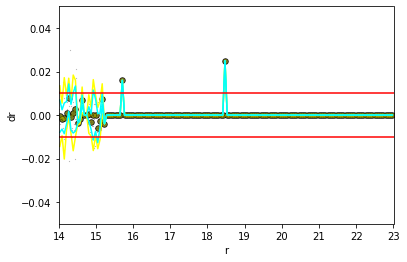

median: -0.0009999999999994458 std.dev: 0.008071671064114053


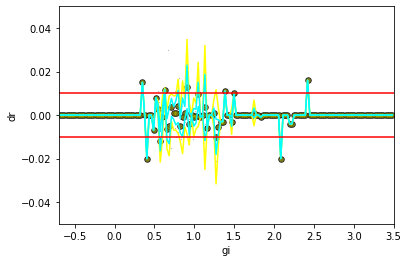

BAND r :  0.3092783505154573 -0.9999999999994458 8.150999999999431


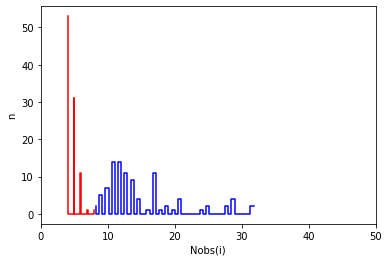

Min:  4 8
Median:  4.0 13.0
sigG:  0.741 4.446
Max:  8 32


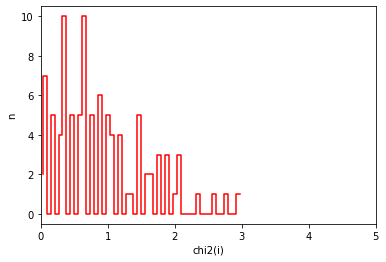

Min:  0.0 20.001
Median:  0.8 23.687
sigG:  0.6669 2.7735630000000016
Max:  3.0 34.951


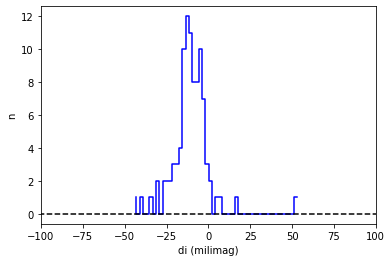

Min, max:  -44.00000000000048 54.00000000000027
Mean, median:  -9.625000000000123 -9.500000000000064
sigG, st.dev.:  7.409999999999842 11.303806512262524
median: -0.009000000000000341 std.dev: 0.036284018822701096


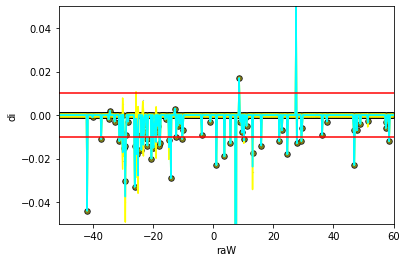

median: -0.009000000000000341 std.dev: 0.04591285760477063


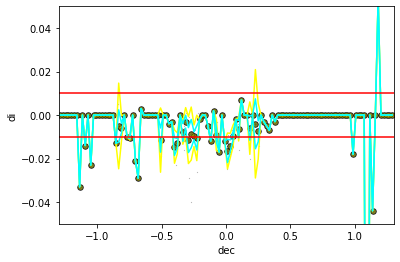

median: -0.009749999999999925 std.dev: 0.011859158841903661


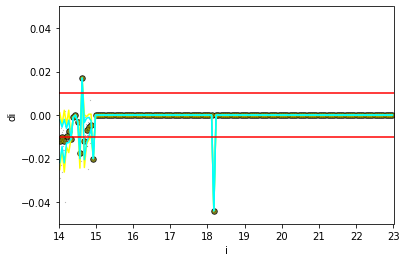

median: -0.010000000000000675 std.dev: 0.012087615713982576


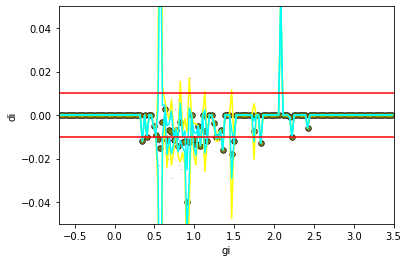

BAND i :  -9.625000000000123 -9.500000000000064 7.409999999999842


In [59]:
for b in ('g', 'r', 'i'):
    meanDM, medianDM, sigDM = makeAllPlots(mOKc1, b)
    print('BAND', b, ': ', meanDM, medianDM, sigDM)

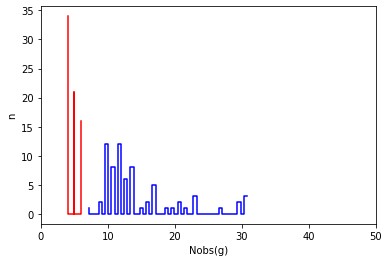

Min:  4 7
Median:  5.0 13.0
sigG:  0.741 4.446
Max:  6 31


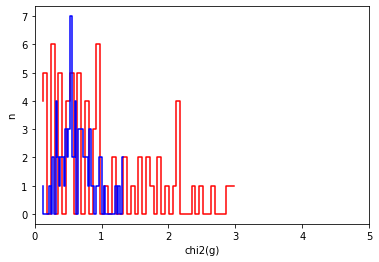

Min:  0.1 0.109
Median:  0.8 0.624
sigG:  0.85215 0.2323035
Max:  3.0 1.335


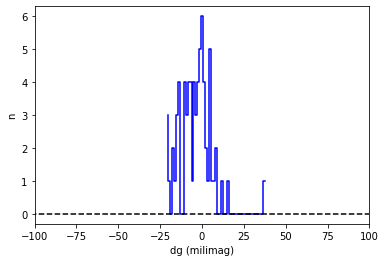

Min, max:  -21.000000000000796 38.000000000000256
Mean, median:  -3.323943661971715 -3.0000000000001137
sigG, st.dev.:  8.521499999999884 9.554550052255198
median: -0.002500000000000391 std.dev: 0.009576248159304948


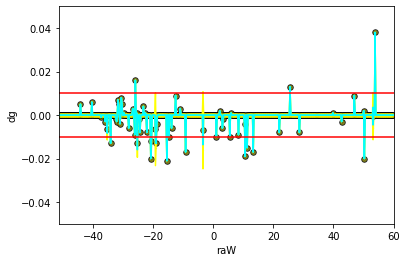

median: -0.0039999999999995595 std.dev: 0.007743138416462968


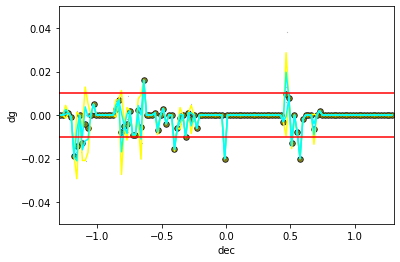

median: -0.0030000000000001137 std.dev: 0.006973136322883154


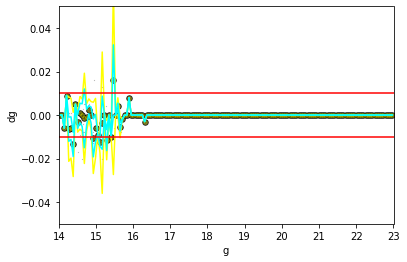

median: -0.0034999999999998366 std.dev: 0.008042525860836532


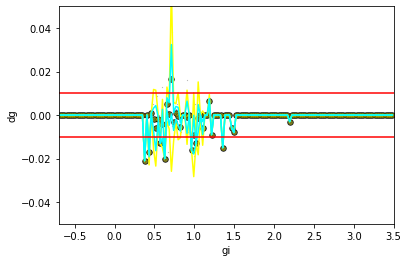

BAND g :  -3.323943661971715 -3.0000000000001137 8.521499999999884


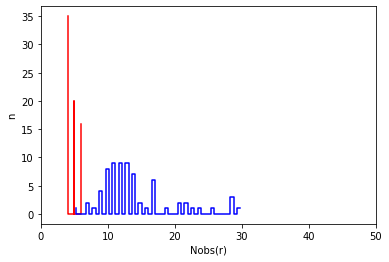

Min:  4 5
Median:  5.0 13.0
sigG:  0.741 4.0755
Max:  6 30


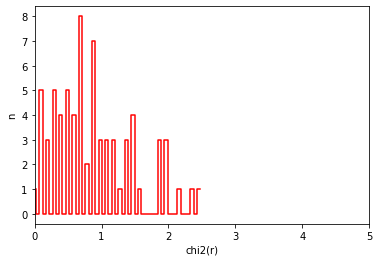

Min:  0.0 20.575
Median:  0.8 25.735
sigG:  0.5928 3.6242309999999986
Max:  2.5 45.166


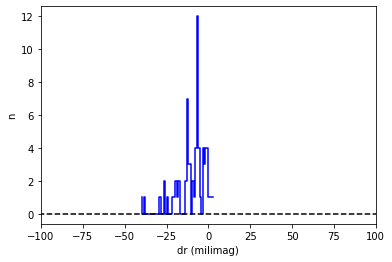

Min, max:  -39.99999999999915 3.0000000000001137
Mean, median:  -9.314285714285703 -6.49999999999995
sigG, st.dev.:  6.483750000000355 8.613184009151844
median: -0.006999999999999673 std.dev: 0.1206623522863588


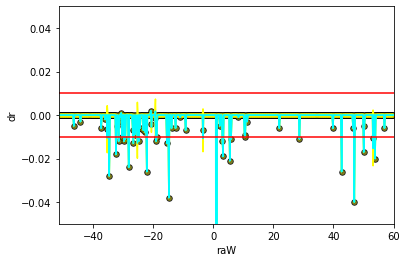

median: -0.006000000000000227 std.dev: 0.07493170136998165


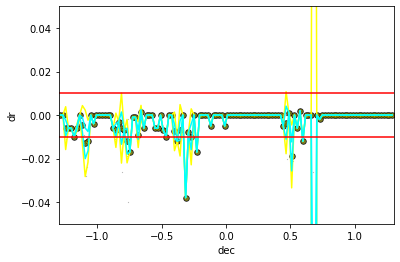

median: -0.008000000000000007 std.dev: 0.12170845857576584


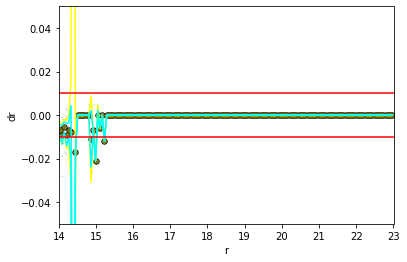

median: -0.009000000000000341 std.dev: 0.08802579956404187


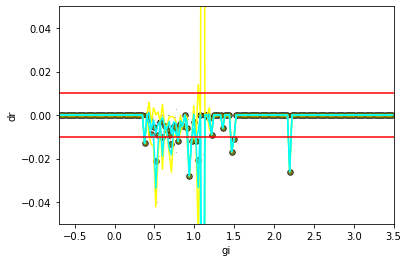

BAND r :  -9.314285714285703 -6.49999999999995 6.483750000000355


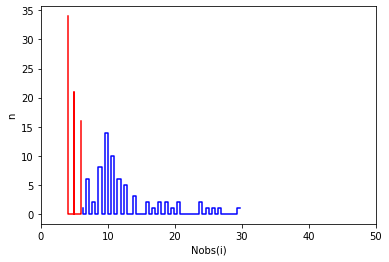

Min:  4 6
Median:  5.0 11.0
sigG:  0.741 2.964
Max:  6 30


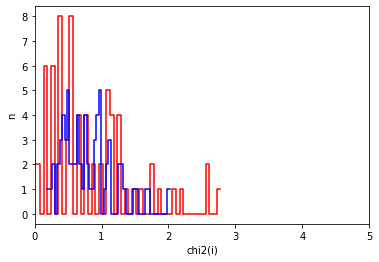

Min:  0.0 0.174
Median:  0.7 0.763
sigG:  0.5928 0.36197850000000004
Max:  2.8 2.034


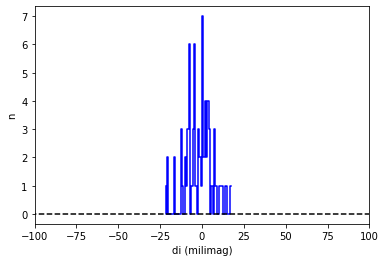

Min, max:  -22.00000000000024 17.999999999998906
Mean, median:  -1.6056338028169372 -1.0000000000012221
sigG, st.dev.:  7.780499999999637 8.255563848547714
median: -0.001000000000000334 std.dev: 0.00759805288971076


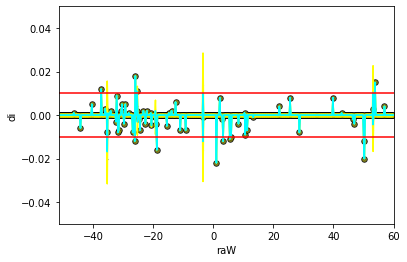

median: -0.001000000000000334 std.dev: 0.008202447892745464


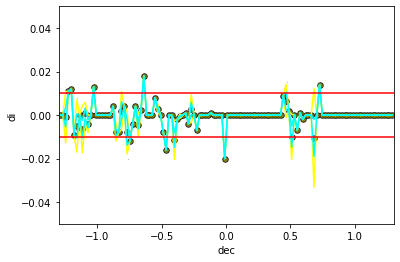

median: 0.0 std.dev: 0.005310211587821963


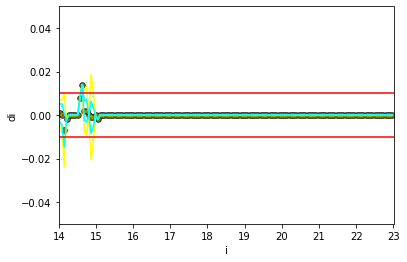

median: -0.002749999999999808 std.dev: 0.006896234882568365


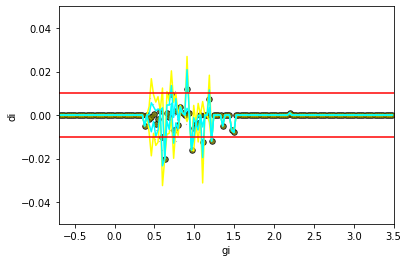

BAND i :  -1.6056338028169372 -1.0000000000012221 7.780499999999637


In [60]:
for b in ('g', 'r', 'i'):
    meanDM, medianDM, sigDM = makeAllPlots(mOKc2, b)
    print('BAND', b, ': ', meanDM, medianDM, sigDM)

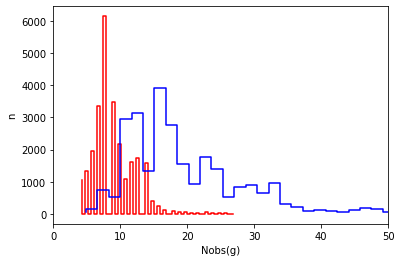

Min:  4 4.0
Median:  8.0 18.0
sigG:  2.964 8.151
Max:  27 91.0


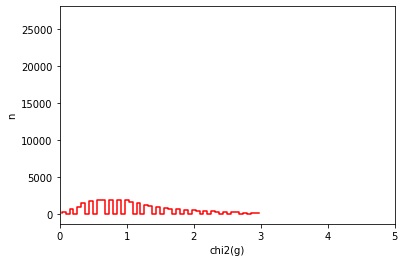

Min:  0.0 0.001
Median:  1.0 21.6935
sigG:  0.6669 36.08873775
Max:  3.0 178882815642.497


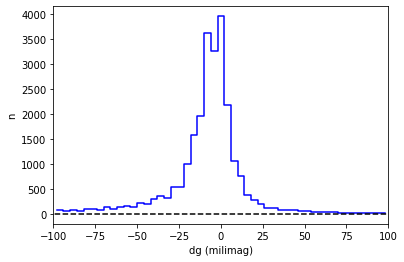

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -6.288641120592493 -3.0000000000001137
sigG, st.dev.:  11.115000000000421 22.058379270934342
median: -0.0034999999999989484 std.dev: 0.0028207424890240363


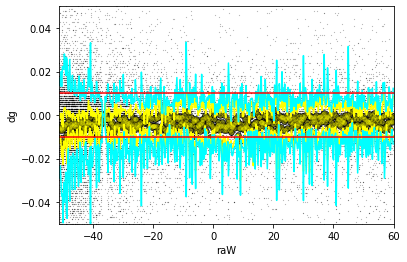

median: -0.0040000000000000036 std.dev: 0.0042190284535233


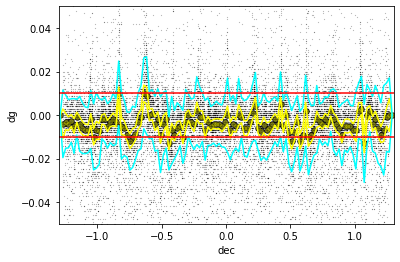

median: -0.0030000000000001137 std.dev: 0.025945713701048437


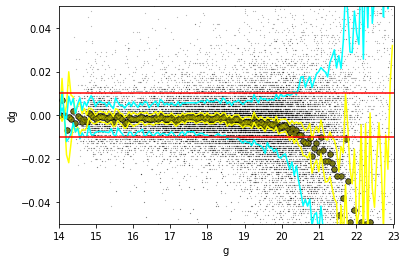

median: -0.006000000000000227 std.dev: 0.12318214149609785


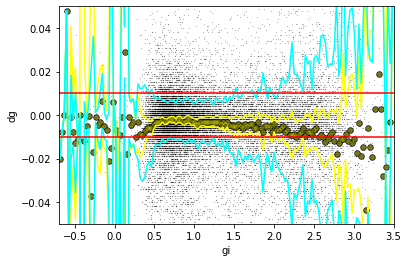

BAND g :  -6.288641120592493 -3.0000000000001137 11.115000000000421


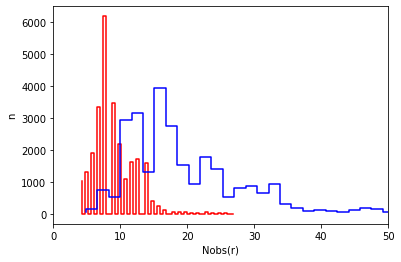

Min:  4 4
Median:  8.0 18.0
sigG:  2.964 8.151
Max:  27 91


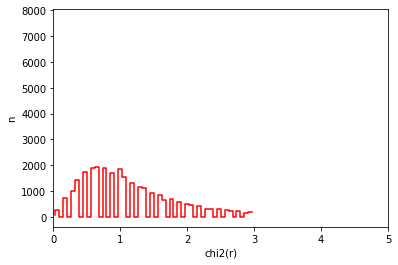

Min:  0.0 20.001
Median:  1.0 66.57849999999999
sigG:  0.6669 89.87607524999999
Max:  3.0 999.893


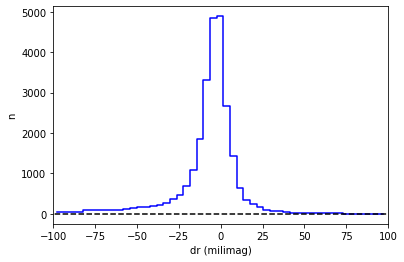

Min, max:  -99.99999999999787 99.0000000000002
Mean, median:  -5.294799266513205 -1.9999999999988916
sigG, st.dev.:  8.892000000000337 19.24184769235193
median: -0.0019999999999988916 std.dev: 0.002183228511303847


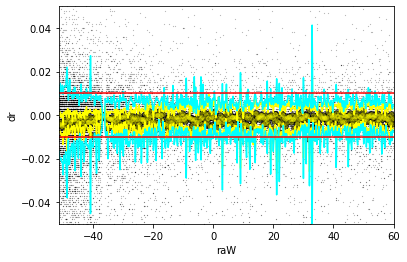

median: -0.002500000000001279 std.dev: 0.003408866044658677


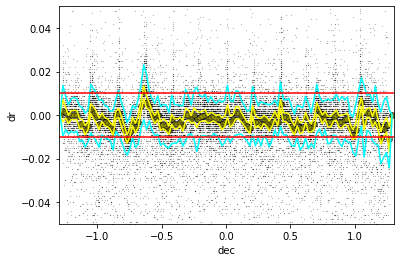

median: -0.0019999999999988916 std.dev: 0.018162270420377293


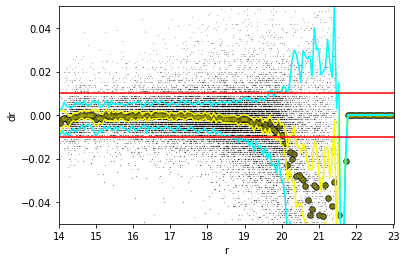

median: -0.0030000000000001137 std.dev: 0.09510651298939624


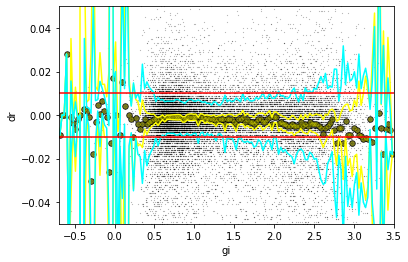

BAND r :  -5.294799266513205 -1.9999999999988916 8.892000000000337


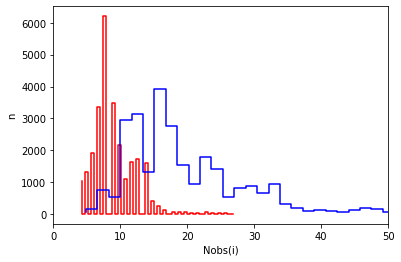

Min:  4 4.0
Median:  8.0 18.0
sigG:  2.964 8.151
Max:  27 91.0


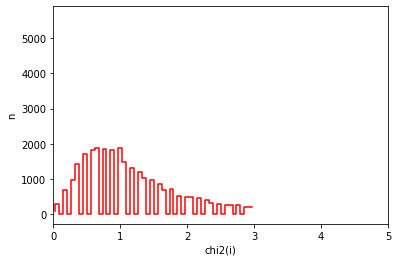

Min:  0.0 20.002
Median:  1.0 82.85249999999999
sigG:  0.6669 104.2857465
Max:  3.0 999.329


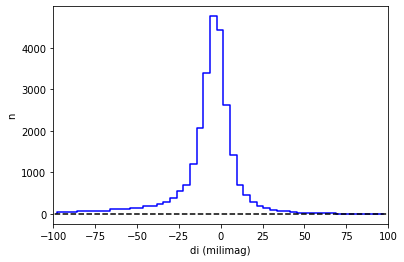

Min, max:  -99.99999999999787 99.0000000000002
Mean, median:  -5.085061757166163 -2.000000000000668
sigG, st.dev.:  8.892000000000337 18.788010711376216
median: -0.0020000000000024443 std.dev: 0.0022297111029227212


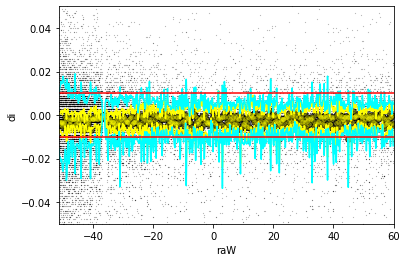

median: -0.00274999999999892 std.dev: 0.003942538744197321


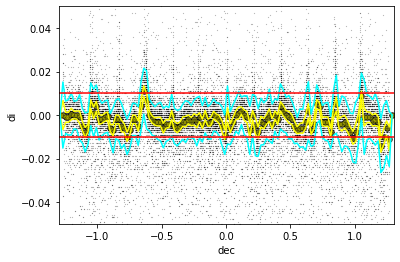

median: -0.002000000000000668 std.dev: 0.08423422765604387


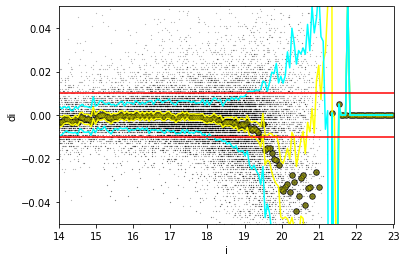

median: -0.0030000000000001137 std.dev: 0.07470085665706573


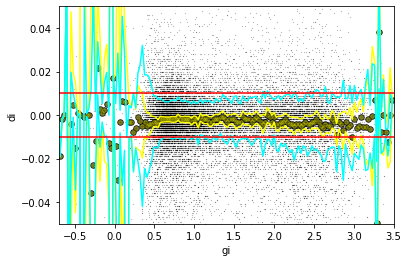

BAND i :  -5.085061757166163 -2.000000000000668 8.892000000000337


In [79]:
for b in ('g', 'r', 'i'):
    meanDM, medianDM, sigDM = makeAllPlots(mOKc3, b)
    print('BAND', b, ': ', meanDM, medianDM, sigDM)

In [61]:
mOKbright = mOK[mOK['g']<20.5] 

median: 0.0 std.dev: 0.003717212790235938


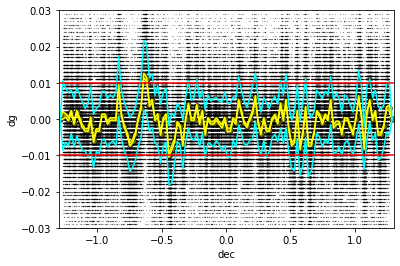

In [62]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dg', -0.03, 0.03, 120) 

median: 0.0 std.dev: 0.002814391979097244


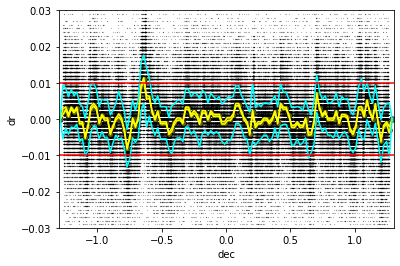

In [63]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dr', -0.03, 0.03, 120) 

median: 0.0 std.dev: 0.00340066066548711


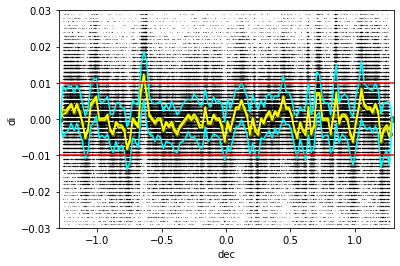

In [64]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'di', -0.03, 0.03, 120) 

In [65]:
## systematics wrt Dec look very similar in gri; check g-r and r-i systematics

In [66]:
mOKbright['dgr'] = mOKbright['dg'] - mOKbright['dr'] 
mOKbright['dri'] = mOKbright['dr'] - mOKbright['di'] 

median: -0.001000000000000334 std.dev: 0.003103075199964869


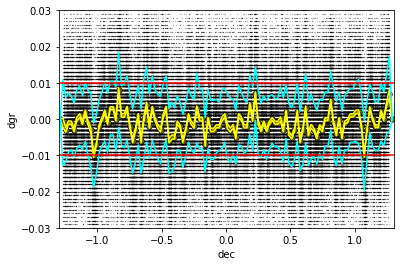

In [67]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dgr', -0.03, 0.03, 120) 

median: 2.6645352591003757e-15 std.dev: 0.0020733635815319636


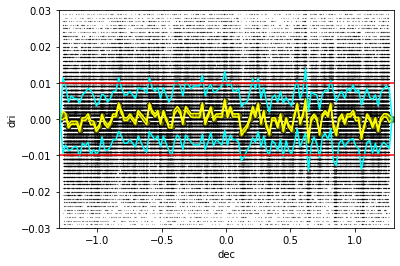

In [68]:
qpBM(mOKbright, 'dec', -1.3, 1.3, 'dri', -0.03, 0.03, 120) 

In [69]:
### CONCLUSION: need to correct for Dec systematics, at least with a gray correction 
# check also u and z bands for systematics 

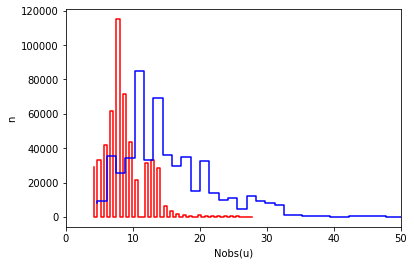

Min:  4 4
Median:  8.0 15.0
sigG:  2.964 5.928
Max:  28 75


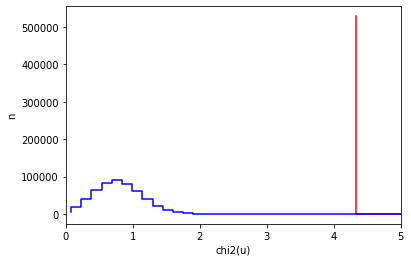

Min:  0.0 0.0
Median:  1.0 0.847
sigG:  0.5928 0.35419799999999996
Max:  441.7 7.778


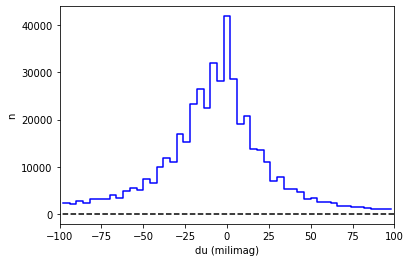

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -5.408956023844381 -3.999999999997783
sigG, st.dev.:  24.45300000000356 32.73558058334413
median: -0.006999999999997897 std.dev: 0.0016506531379344473


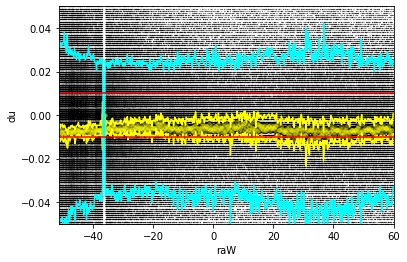

median: -0.006000000000000227 std.dev: 0.01071123415867444


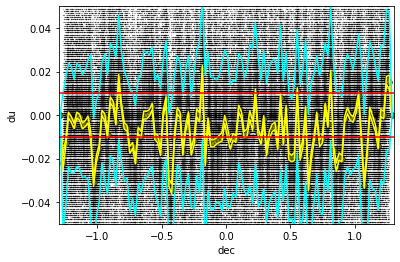

median: -0.0030000000000001137 std.dev: 0.029257574810956522


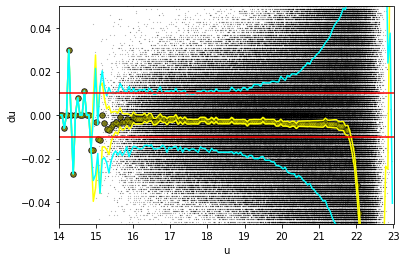

median: -0.00999999999999801 std.dev: 0.03096332884774066


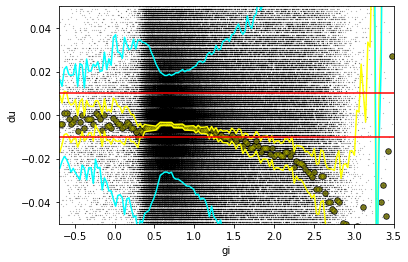

BAND u :  -5.408956023844381 -3.999999999997783 24.45300000000356


In [70]:
b = 'u'
meanDM, medianDM, sigDM = makeAllPlots(mOKu, b)
print('BAND', b, ': ', meanDM, medianDM, sigDM)

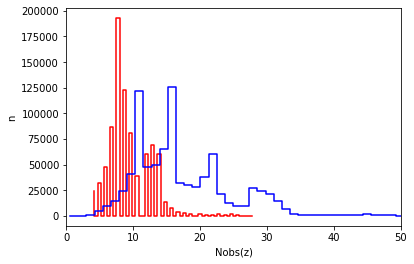

Min:  4 0
Median:  9.0 16.0
sigG:  2.964 7.41
Max:  28 62


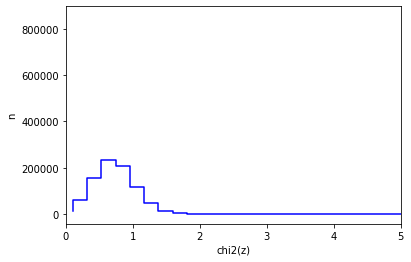

Min:  0.0 0.0
Median:  1.0 0.821
sigG:  0.5928 0.2993639999999999
Max:  2087.2 10.854


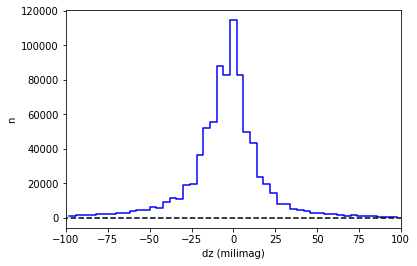

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -2.463895521002948 -1.0000000000012221
sigG, st.dev.:  14.079000000001411 23.14754481204564
median: -0.0010000000000012221 std.dev: 0.0006348064615857407


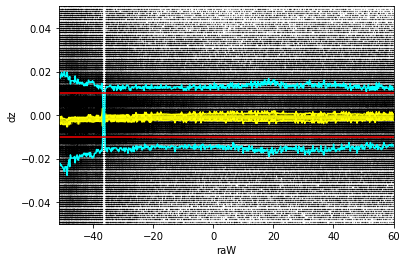

median: -0.0010000000000012221 std.dev: 0.004668076318195317


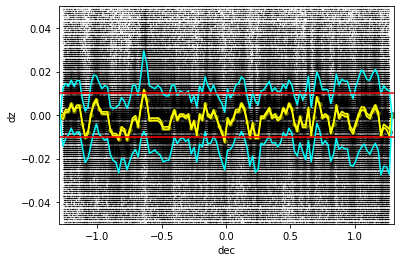

median: -0.0009999999999976694 std.dev: 0.008954777851855904


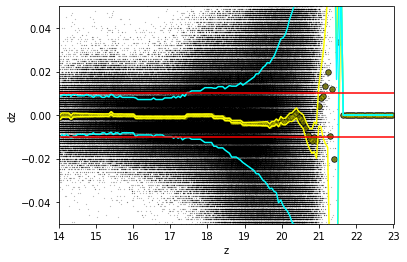

median: -0.0010000000000012221 std.dev: 0.005039291175904794


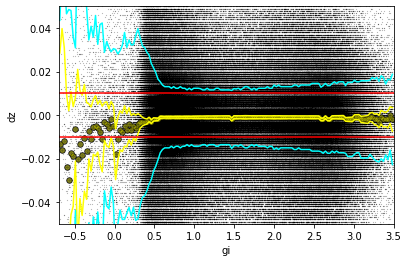

BAND z :  -2.463895521002948 -1.0000000000012221 14.079000000001411


In [71]:
b = 'z'
meanDM, medianDM, sigDM = makeAllPlots(mOKz, b)
print('BAND', b, ': ', meanDM, medianDM, sigDM)

277574


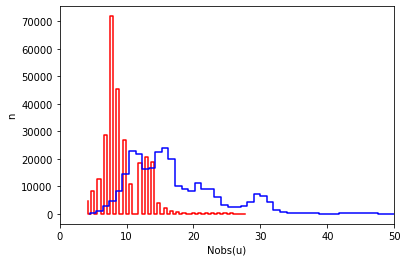

Min:  4 4
Median:  9.0 16.0
sigG:  2.223 6.669
Max:  28 54


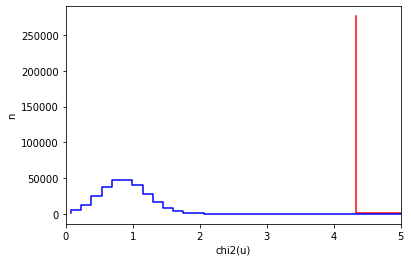

Min:  0.0 0.0
Median:  1.2 0.945
sigG:  0.6668999999999999 0.342342
Max:  441.7 7.778


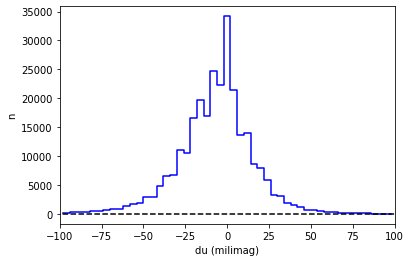

Min, max:  -99.99999999999787 99.99999999999787
Mean, median:  -4.916118057142437 -3.0000000000001137
sigG, st.dev.:  17.784000000000674 21.959819776377167
median: -0.0030000000000001137 std.dev: 0.0010423137261882244


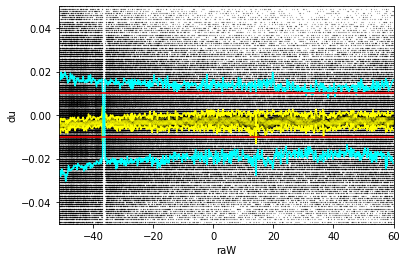

median: -0.0030000000000001137 std.dev: 0.010258653097390194


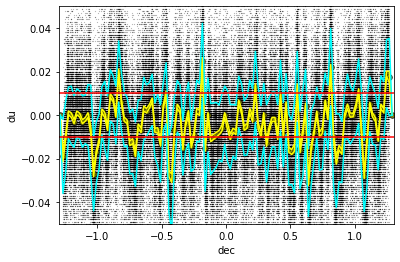

median: -0.0030000000000001137 std.dev: 0.0008880341652426888


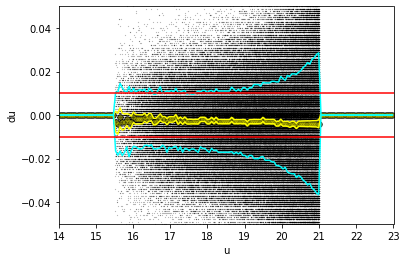

median: -0.0030000000000001137 std.dev: 0.010706828485376867


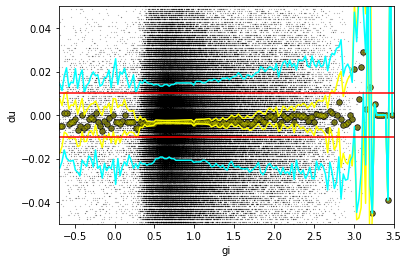

BAND u :  -4.916118057142437 -3.0000000000001137 17.784000000000674


In [72]:
## check bright end for u subsample 
mOKuB = mOKu[(mOKu['u']>15.5)&(mOKu['u']<21)]
print(np.size(mOKuB))
b = 'u'
meanDM, medianDM, sigDM = makeAllPlots(mOKuB, b)
print('BAND', b, ': ', meanDM, medianDM, sigDM)

In [73]:
## check u-g color systematics vs. Dec for bright u subsample
mOKuB['dug'] = mOKuB['du'] - mOKuB['dg']   

median: -0.0034999999999989484 std.dev: 0.008066875214441126


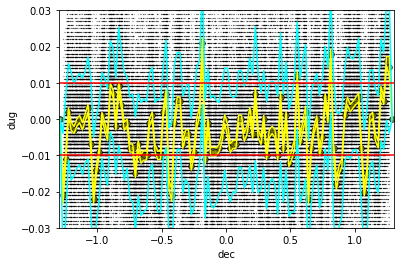

In [74]:
qpBM(mOKuB, 'dec', -1.3, 1.3, 'dug', -0.03, 0.03, 120) 

In [75]:
## check color systematics vs. Dec for bright z subsample
mOKzB = mOKz[(mOKz['z']>14)&(mOKz['z']<20)]
print(np.size(mOKzB))
mOKzB['dri'] = mOKzB['dr'] - mOKzB['di']  
mOKzB['diz'] = mOKzB['di'] - mOKzB['dz']  

742549


median: -0.0010000000000012221 std.dev: 0.004639402890286501


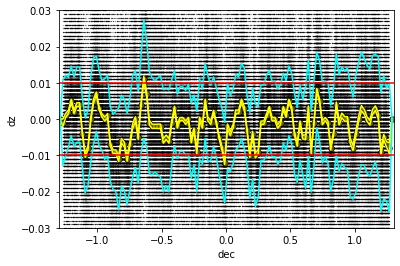

In [76]:
qpBM(mOKzB, 'dec', -1.3, 1.3, 'dz', -0.03, 0.03, 120) 

median: 0.0010000000000012221 std.dev: 0.00255509879974757


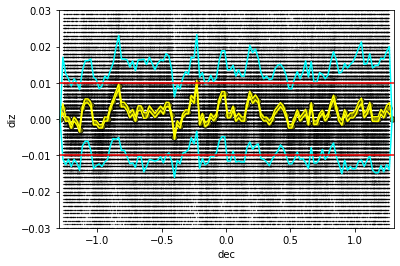

In [77]:
qpBM(mOKzB, 'dec', -1.3, 1.3, 'diz', -0.03, 0.03, 120) 

median: 0.0 std.dev: 0.001990587590216108


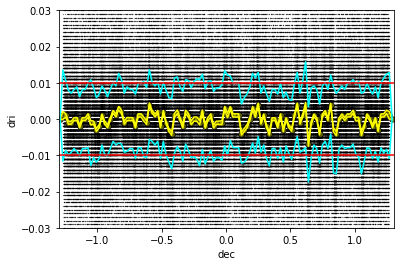

In [78]:
qpBM(mOKzB, 'dec', -1.3, 1.3, 'dri', -0.03, 0.03, 120) 